In [18]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
sys.path.append('..') 
import platform
import os
from pathlib import Path
import shutil
from utils.basics.data_org import curr_computer, move_subfolders
from pathlib import Path
import shutil
from utils.behavior.session_utils import clean_up_licks, load_df_from_mat, load_session_df
from scipy.io import loadmat
from itertools import chain
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.signal import find_peaks
# %matplotlib inline
%matplotlib widget

In [2]:
session_df, licks_L, licks_R = load_session_df('m754895d20250109')

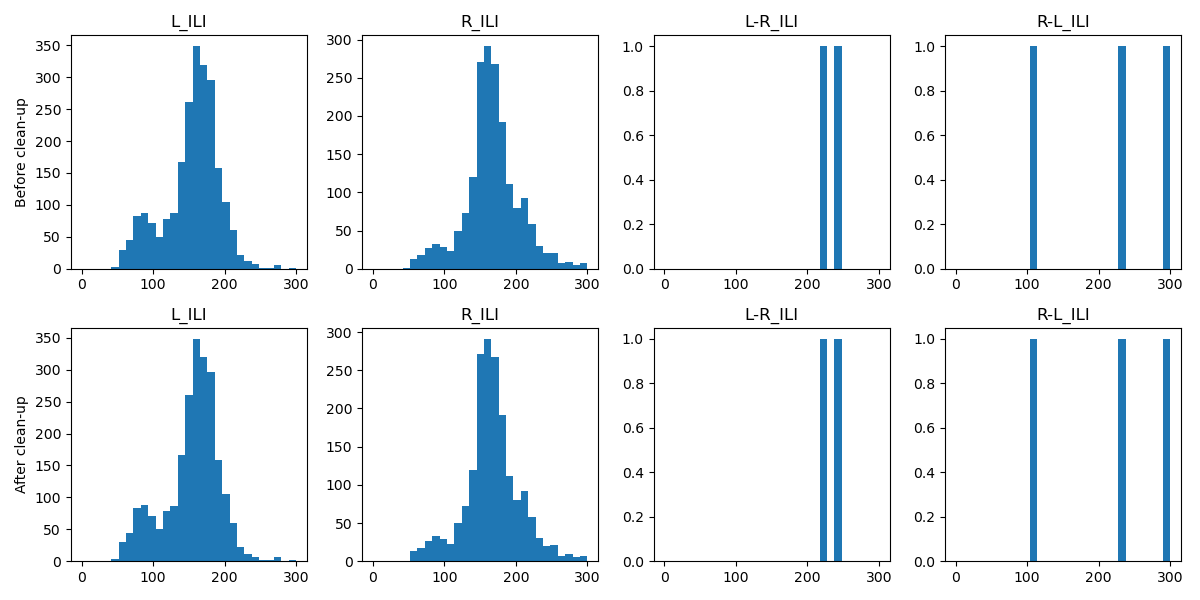

In [7]:
cleaned_licks_L, cleaned_licks_R, fig = clean_up_licks(licks_L, licks_R, plot=True)

In [29]:
from scipy.signal import find_peaks
licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
# Sample event times (in seconds)
X = np.array(licks_L)
bin_size = 50
licks_binned = np.histogram(X, bins=np.arange(X.min(), X.max(), bin_size))[0]/(bin_size/1000)
time_binned = np.arange(X.min(), X.max(), bin_size)[:-1] + 0.5*bin_size
window_size = 1000
licks_smoothed = np.convolve(licks_binned, np.ones(int(window_size/bin_size))/(window_size/bin_size), mode='same')

In [30]:
peaks, _ = find_peaks(licks_smoothed, height = 2, distance = 2*1000/bin_size)

C:\Users\zhixi\AppData\Local\Temp\ipykernel_57024\501443765.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20, 5))


(340000.0, 360000.0)

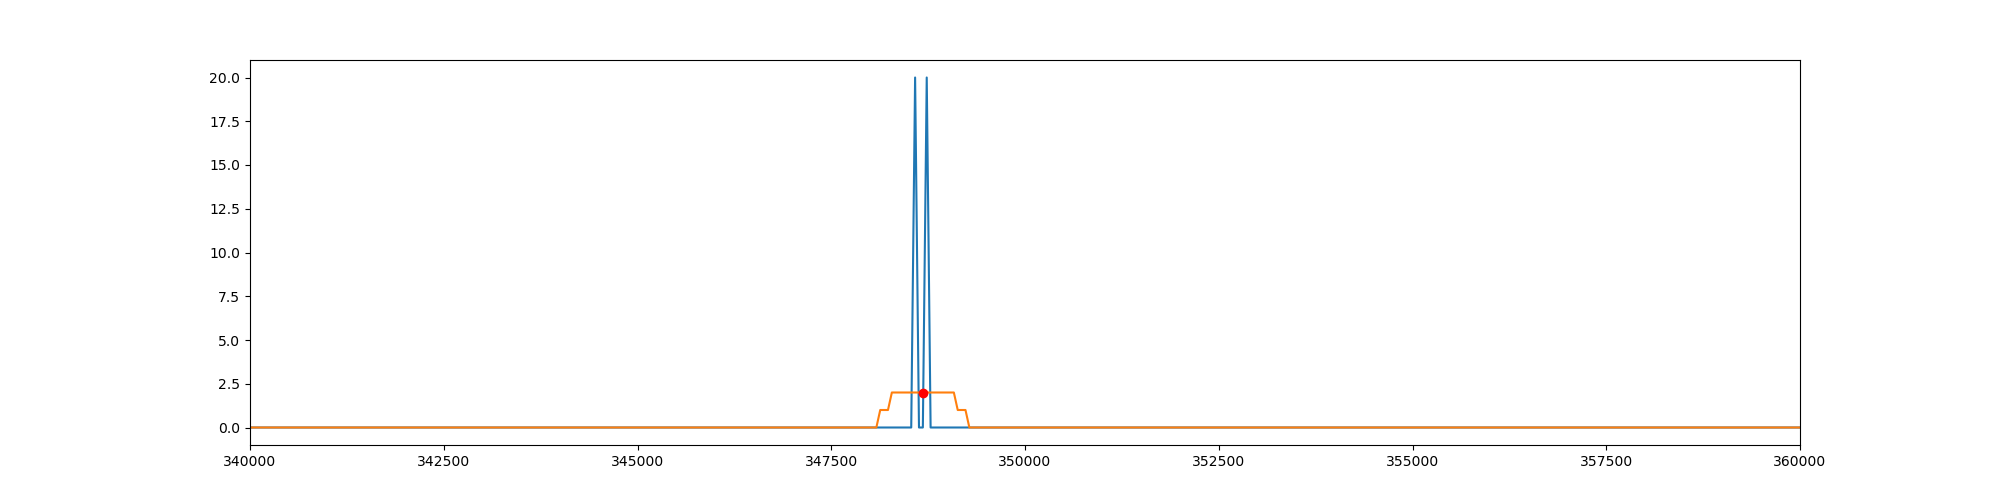

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.scatter(time_binned[peaks], licks_smoothed[peaks], color='r', zorder = 3)
plt.plot(time_binned, licks_binned, zorder = 1)

plt.plot(time_binned, licks_smoothed, zorder = 2) 

plt.xlim(340000, 360000)

In [ ]:

# Define the window size for the running average (5 seconds)
window_size = 5*1000

# Compute the running average using a simple moving average
# 'mode' = 'valid' ensures the result has no NaN values at the boundaries
running_avg = np.convolve(X, np.ones(window_size)/window_size, mode='valid')


In [39]:
pip install ipympl


   ---------------------------------------- 0.0/515.7 kB ? eta -:--:--
   -------- ------------------------------- 112.6/515.7 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 515.7/515.7 kB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/139.8 kB ? eta -:--:--
   ---------------------------------------- 139.8/139.8 kB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/214.4 kB ? eta -:--:--
   --------------------------------------- 214.4/214.4 kB 13.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   -------------------------- ------------- 1.5/2.3 MB 49.5 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 49.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:

# Detect peaks in the running average
peaks, _ = find_peaks(running_avg)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the event times
plt.plot(X, np.zeros_like(X), 'bo', label='Event Times')

# Plot the running average
plt.plot(np.arange(window_size - 1, len(X)), running_avg, label='Running Average (5s)', color='green')

# Plot the detected peaks
plt.plot(peaks + window_size - 1, running_avg[peaks], 'ro', label='Detected Peaks')

plt.title('Running Average and Peak Detection')
plt.xlabel('Time (s)')
plt.ylabel('Event Density')
plt.legend()
plt.grid(True)
plt.show()
